# Problema 2: Optimización Multiobjetivo en Planificación de Rutas de Inspección

In [2]:
import numpy as np
import csv

def read_cost_matrix_csv(filename):
    with open(filename, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        # Read the first row to get the node IDs.
        node_ids = next(reader)
        # Read the remaining rows as data.
        data = list(reader)
    
    # Convert the data to a numpy array.
    cost_matrix = np.array(data, dtype=int)
    
    return cost_matrix

print('Matriz de distancias:')
print(read_cost_matrix_csv('matriz_distancias_punto2.csv'))

print('Matriz riesgos:')
print(read_cost_matrix_csv('matriz_riesgos_punto2.csv'))

lista_calidades = [0,85,92,78,90,82,88,95,75,84]
print(lista_calidades)

Matriz de distancias:
[[0 3 1 3 2 2 5 3 1 2]
 [3 0 4 2 3 3 5 1 2 3]
 [1 4 0 3 2 2 5 3 2 2]
 [3 2 3 0 1 2 3 3 2 2]
 [2 3 2 1 0 1 3 3 2 1]
 [2 3 2 2 1 0 3 4 2 0]
 [5 5 5 3 3 3 0 6 5 4]
 [3 1 3 3 3 4 6 0 1 4]
 [1 2 2 2 2 2 5 1 0 2]
 [2 3 2 2 1 0 4 4 2 0]]
Matriz riesgos:
[[0 3 2 4 5 6 3 2 4 5]
 [5 0 5 5 5 5 5 5 5 5]
 [5 5 0 5 5 5 5 5 9 8]
 [5 5 5 0 5 5 5 5 5 5]
 [5 5 5 5 0 5 5 5 5 7]
 [5 5 5 5 5 0 7 5 5 5]
 [5 5 5 5 5 5 0 5 5 5]
 [5 5 5 5 5 5 5 0 5 5]
 [5 5 5 5 5 5 5 5 0 7]
 [5 5 5 5 5 5 5 5 5 0]]
[0, 85, 92, 78, 90, 82, 88, 95, 75, 84]


## Paso 1: Definición del modelo

#### Variables

- $x_{i,j} \in {0, 1}$ variable de decisión para determinar si se elije el camino desde el nodo $i$ al nodo $j$
- $u_i$ variable auxiliar para la eliminación de subtures en el recorrido de los nodos

#### Conjuntos

Conjunto de Nodos:
- $C = C_1, C_2,\dots, C_n$

#### Parámetros

- $c_{i,j}$ costo de ir del nodo $i$ al nodo $j$, $\forall i,j \in C$
- $r_{i,j}$ riesgo de ir del nodo $i$ al nodo $j$, $\forall i,j \in C$
- $q_i$ puntos de calidad de visitar el nodo $i$, $\forall i \in C$




## Método de solución: $\epsilon$-constraint
Para resolver este ejercicio, se decidió utilizar el método de $\epsilon$-constraint. Dado que este método optimiza únicamente una función objetivo, se decidió que para la primera iteración se iba a optimizar el costo total del recorrido, y las otras optimizaciones (maximizar los puntos de calidad y minimizar el riesgo) serán restricciones.

#### Función Objetivo

$$
min(\sum_{i \in C}\sum_{j \in C} c_{i,j} * x_{i,j})
$$

#### Restricciones

- Cada ciudad $i$ tiene exactamente un arco de entrada y un arco de salida
$$
\sum_{j \in C, j \neq i} x_{i,j} = 1, \forall i \in C
$$
$$
\sum_{i \in C, i \neq j} x_{i,j} = 1, \forall j \in C
$$
- Restricción $\epsilon$ sobre los puntos de calidad
$$
\sum_{i \in C} n_i * q_i \ge \epsilon _{puntosCalidad}
$$
- Restricción $\epsilon$ sobre el factor de riesgo
$$
\sum_{i \in C} \sum_{j \in C, j \neq i} x_{i,j} \cdot r_{i,j} \le \epsilon _{riesgo}
$$
- Eliminación de los subtures

$$
u_i - u_j + n*x_{i,j} \leq n - 1, \forall i \neq j, i,j \in {1,\dots, n-1 } 
$$

## Paso 2: Encontrar los valores de $\epsilon$

Antes de resolver el ejercicio actual, es necesario resolver para obtener los valores óptimos de los epsilons usados, los cuales dependen del problema.
- Para el $\epsilon$ de los puntos de calidad, se va a modelar la función mono objetivo que maximice la cantidad de puntos, la cual se calcula como
$$
max \sum_{i \in C} \sum_{j \in C, j \neq i} x_{i,j} \cdot q_i
$$
# Optimización mono Objetivo 1:
Se utilizará una modificación del modelo usado para el punto 5 del laboratorio 2, el cual va a buscar realizar una maximización de los puntos de calidad obtenidos.

In [3]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt

class Optimization:
    """
    A basic TSP model for a single driver (one route) without subtour elimination.
    It uses a cost matrix to define travel costs between cities and ensures that
    each city is visited exactly once (inbound=1, outbound=1) but does NOT include
    additional constraints to prevent subtours.

    Attributes:
        cost_matrix (list of lists): 2D matrix of travel costs between cities.
        num_cities (int): Number of cities (inferred from cost_matrix).
        model (pyo.ConcreteModel): The Pyomo model built in `model()`.

    Methods:
        model(): Builds the Pyomo model with variables, objective, and constraints.
        print_model(): Prints the Pyomo model structure.
        solve_model(): Solves the model using the 'appsi_highs' solver (by default).
        print_output(): Prints/plots the resulting route(s) as a directed graph.
    """

    def __init__(self, cost_matrix, points_array):
        self.cost_matrix = cost_matrix
        self.points = points_array
        self.num_cities = len(cost_matrix)
 

    def model(self):
        self.model = pyo.ConcreteModel()
        self.model.N = pyo.RangeSet(0, self.num_cities-1)
        self.model.x = pyo.Var(self.model.N, self.model.N, within=pyo.Binary)
        self.model.u = pyo.Var(self.model.N, within=pyo.NonNegativeIntegers, bounds=(0, self.num_cities - 1))
        def cost_init(model, i, j):
            return self.cost_matrix[i][j]
        self.model.c = pyo.Param(self.model.N, self.model.N, initialize=cost_init)
        def point_init(model, j):
            return self.points[j - 1]
        self.model.p = pyo.Param(self.model.N, initialize=point_init)

        def _objective_function(model):
            return sum(model.x[i, j] * model.c[i, j] * model.p[j]
                    for i in model.N for j in model.N)
        self.model.objective = pyo.Objective(rule=_objective_function,
                                            sense=pyo.maximize)

        def _outbound_rule(model, i):
            return sum(model.x[i, j] for j in model.N if j != i) == 1
        self.model.outbound = pyo.Constraint(self.model.N, rule=_outbound_rule)

        def _inbound_rule(model, j):
            return sum(model.x[i, j] for i in model.N if i != j) == 1
        self.model.inbound = pyo.Constraint(self.model.N, rule=_inbound_rule)

        def _no_self_loops(model, i):
            return model.x[i, i] == 0
        self.model.no_self_loops = pyo.Constraint(self.model.N, rule=_no_self_loops)

        def _subtour_elimination(model, i, j):
            if i != j and i != 1 and j != 1:
                return model.u[i] - model.u[j] + self.num_cities * model.x[i, j] <= self.num_cities - 1
            else:
                return pyo.Constraint.Skip

        self.model.subtour_elimination = pyo.Constraint(self.model.N, self.model.N, rule=_subtour_elimination)
        

    def print_model(self):
        """Prints the model structure."""
        self.model.pprint()

    def solve_model(self):
        """Solves the TSP model using the 'glpk' solver."""
        solver = pyo.SolverFactory('glpk')
        result = solver.solve(self.model, tee=True)
        print(result)

    def print_output(self):
        """
        Plots the solution as a directed graph using NetworkX and matplotlib.
        Since there's only one route (single driver), all edges are colored the same.
        """
        total_weighted_score = 0
        valid_edges = []
        for i in self.model.N:
            for j in self.model.N:
                if pyo.value(self.model.x[i, j]) > 0.5:
                    weighted_score = self.cost_matrix[i][j] * self.points[j]
                    total_weighted_score += weighted_score
                    valid_edges.append((i, j))


        # Build a directed graph
        G = nx.DiGraph()
        G.add_nodes_from(self.model.N)

        # Add edges from the solution
        for (i, j) in valid_edges:
            G.add_edge(i, j)

        pos = nx.spring_layout(G)
        nx.draw_networkx(G, pos, with_labels=True,
                         node_color='lightblue',
                         edge_color='red',
                         arrows=True)
        plt.axis("off")
        plt.show()
        print("Total de puntos del recorrido:", total_weighted_score)
        print("Ruta óptima:", valid_edges)


In [4]:
matriz_costos =  read_cost_matrix_csv('matriz_distancias_punto2.csv')
opt = Optimization(matriz_costos, lista_calidades)
opt.model()
opt.solve_model()

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\57304\AppData\Local\Temp\tmpppy6dq0r.glpk.raw --wglp C:\Users\57304\AppData\Local\Temp\tmpjxyeek0s.glpk.glp
 --cpxlp C:\Users\57304\AppData\Local\Temp\tmpig164hc7.pyomo.lp
Reading problem data from 'C:\Users\57304\AppData\Local\Temp\tmpig164hc7.pyomo.lp'...
C:\Users\57304\AppData\Local\Temp\tmpig164hc7.pyomo.lp:920: warning: lower bound of variable 'x113' redefined
C:\Users\57304\AppData\Local\Temp\tmpig164hc7.pyomo.lp:920: warning: upper bound of variable 'x113' redefined
102 rows, 109 columns, 406 non-zeros
109 integer variables, 100 of which are binary
1020 lines were read
Writing problem data to 'C:\Users\57304\AppData\Local\Temp\tmpjxyeek0s.glpk.glp'...
800 lines were written
GLPK Integer Optimizer 5.0
102 rows, 109 columns, 406 non-zeros
109 integer variables, 100 of which are binary
Preprocessing...
92 rows, 99 columns, 396 non-zeros
99 integer variables, 90 of which are binary
Scaling..

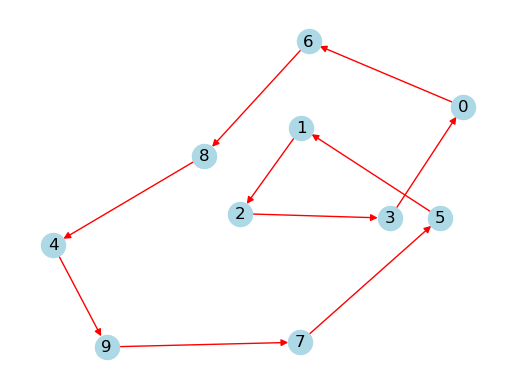

Total de puntos del recorrido: 2644
Ruta óptima: [(0, 6), (1, 2), (2, 3), (3, 0), (4, 9), (5, 1), (6, 8), (7, 5), (8, 4), (9, 7)]


In [5]:
opt.print_output()

Con esto se puede asegurar que el máximo valor posible, si se decide optimizar estrictamente por los puntos de calidad, es 2644. Este será nuestro tope máximo para el valor epsilon, el menor se calculará buscando el peor escenario posible:

In [6]:
summin = 0
def min_fila (fila):
    minAct = 100
    for intento in fila:
        if intento>0 and intento<minAct:
            minAct = intento
    return minAct
'''Se calcula el máximo posible de riesgo obtenible, el cual se obtiene tomando en cuenta que,
como se tienen que recorrer los 10 puntos, el peor escenario sería tomar el arco
con la mayor cantidad de riesgo por cada uno de los nodos'''
for filanum in range(len(matriz_costos)):
    minimo = min_fila(matriz_costos[filanum])
    summin += minimo* lista_calidades[filanum]
print(f'Mínimo posible de riesgo es: {summin}')

Mínimo posible de riesgo es: 945


Entonces se tiene que:
$$
945 \le \epsilon_{puntosCalidad} \le 2644
$$


- Para el $\epsilon$ del riesgo, se va a modelar la función mono-Objetivo que minimice el riesgo necesario para visitar todos los nodos, para obtener el menor valor posible y variar el valor de $\epsilon_{riesgo}$ teniendo eso en cuenta:
# Optimización mono Objetivo 2:
Se utilizará el mismo modelo entregado para resolver el punto 5 del Laboratorio 2. Esto es porque este modelo optimiza una única función objetivo, que es lo que queremos para encontrar el mínimo global de querer minimizar el factor de riesgo de realizar el recorrido.

In [7]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt

class Optimization:
    """
    A basic TSP model for a single driver (one route) without subtour elimination.
    It uses a cost matrix to define travel costs between cities and ensures that
    each city is visited exactly once (inbound=1, outbound=1) but does NOT include
    additional constraints to prevent subtours.

    Attributes:
        cost_matrix (list of lists): 2D matrix of travel costs between cities.
        num_cities (int): Number of cities (inferred from cost_matrix).
        model (pyo.ConcreteModel): The Pyomo model built in `model()`.

    Methods:
        model(): Builds the Pyomo model with variables, objective, and constraints.
        print_model(): Prints the Pyomo model structure.
        solve_model(): Solves the model using the 'appsi_highs' solver (by default).
        print_output(): Prints/plots the resulting route(s) as a directed graph.
    """

    def __init__(self, cost_matrix):
        self.cost_matrix = cost_matrix
        self.num_cities = len(cost_matrix) 

    def model(self):
        self.model = pyo.ConcreteModel()
        self.model.N = pyo.RangeSet(0, self.num_cities-1)
        self.model.x = pyo.Var(self.model.N, self.model.N, within=pyo.Binary)
        self.model.u = pyo.Var(self.model.N, within=pyo.NonNegativeIntegers, bounds=(0, self.num_cities - 1))
        def cost_init(model, i, j):
            return self.cost_matrix[i - 1][j - 1]
        self.model.c = pyo.Param(self.model.N, self.model.N, initialize=cost_init)

        def _objective_function(model):
            return sum(model.x[i, j] * model.c[i, j]
                       for i in model.N for j in model.N)
        self.model.objective = pyo.Objective(rule=_objective_function,
                                             sense=pyo.minimize)

        def _outbound_rule(model, i):
            return sum(model.x[i, j] for j in model.N if j != i) == 1
        self.model.outbound = pyo.Constraint(self.model.N, rule=_outbound_rule)

        def _inbound_rule(model, j):
            return sum(model.x[i, j] for i in model.N if i != j) == 1
        self.model.inbound = pyo.Constraint(self.model.N, rule=_inbound_rule)

        def _no_self_loops(model, i):
            return model.x[i, i] == 0
        self.model.no_self_loops = pyo.Constraint(self.model.N, rule=_no_self_loops)

        def _subtour_elimination(model, i, j):
            if i != j and i != 1 and j != 1:
                return model.u[i] - model.u[j] + self.num_cities * model.x[i, j] <= self.num_cities - 1
            else:
                return pyo.Constraint.Skip

        self.model.subtour_elimination = pyo.Constraint(self.model.N, self.model.N, rule=_subtour_elimination)
        

    def print_model(self):
        """Prints the model structure."""
        self.model.pprint()

    def solve_model(self):
        """Solves the TSP model using the 'glpk' solver."""
        solver = pyo.SolverFactory('glpk')
        result = solver.solve(self.model, tee=True)
        print(result)

    def print_output(self):
        """
        Plots the solution as a directed graph using NetworkX and matplotlib.
        Since there's only one route (single driver), all edges are colored the same.
        """
        total_cost = 0
        valid_edges = []
        for i in self.model.N:
            for j in self.model.N:
                if pyo.value(self.model.x[i, j]) > 0.5:
                    total_cost += self.cost_matrix[i - 1][j - 1]
                    valid_edges.append((i, j))

        # Build a directed graph
        G = nx.DiGraph()
        G.add_nodes_from(self.model.N)

        # Add edges from the solution
        for (i, j) in valid_edges:
            G.add_edge(i, j)

        pos = nx.spring_layout(G)
        nx.draw_networkx(G, pos, with_labels=True,
                         node_color='lightblue',
                         edge_color='red',
                         arrows=True)
        plt.axis("off")
        plt.show()
        print("Riesgo total del recorrido:", total_cost)
        print("Ruta óptima:", valid_edges)


In [8]:
matriz_riesgos = read_cost_matrix_csv('matriz_riesgos_punto2.csv')

opt = Optimization(matriz_riesgos)
opt.model()
opt.solve_model()

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\57304\AppData\Local\Temp\tmpvnaktms8.glpk.raw --wglp C:\Users\57304\AppData\Local\Temp\tmp3912aibs.glpk.glp
 --cpxlp C:\Users\57304\AppData\Local\Temp\tmpw_tsuxpn.pyomo.lp
Reading problem data from 'C:\Users\57304\AppData\Local\Temp\tmpw_tsuxpn.pyomo.lp'...
C:\Users\57304\AppData\Local\Temp\tmpw_tsuxpn.pyomo.lp:931: warning: lower bound of variable 'x113' redefined
C:\Users\57304\AppData\Local\Temp\tmpw_tsuxpn.pyomo.lp:931: warning: upper bound of variable 'x113' redefined
102 rows, 109 columns, 406 non-zeros
109 integer variables, 100 of which are binary
1031 lines were read
Writing problem data to 'C:\Users\57304\AppData\Local\Temp\tmp3912aibs.glpk.glp'...
811 lines were written
GLPK Integer Optimizer 5.0
102 rows, 109 columns, 406 non-zeros
109 integer variables, 100 of which are binary
Preprocessing...
92 rows, 99 columns, 396 non-zeros
99 integer variables, 90 of which are binary
Scaling..

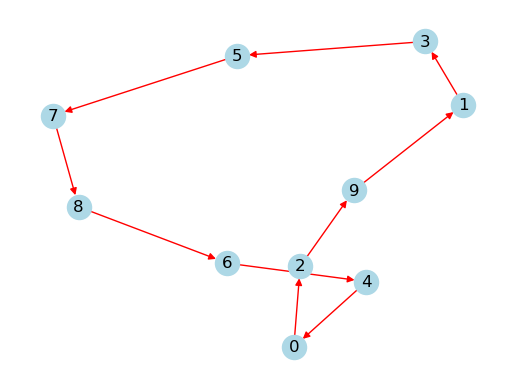

Riesgo total del recorrido: 47
Ruta óptima: [(0, 2), (1, 3), (2, 9), (3, 5), (4, 0), (5, 7), (6, 4), (7, 8), (8, 6), (9, 1)]


In [9]:
opt.print_output()

Dada la optimización se sabe ahora que el valor mínimo de riesgo que se puede conseguir es 47

In [10]:
summax = 0
'''Se calcula el máximo posible de riesgo obtenible, el cual se obtiene tomando en cuenta que,
como se tienen que recorrer los 10 puntos, el peor escenario sería tomar el arco
con la mayor cantidad de riesgo por cada uno de los nodos'''
for fila in matriz_riesgos:
    summax+= max(fila)
print(f'Máximo posible de riesgo es: {summax}')

Máximo posible de riesgo es: 61


Ahora se sabe que el máximo de riesgo posible es 61, por lo que podemos afirmar que:
$$
47\le \epsilon _{riesgo} \le 61
$$

## Paso final: Optimización multiobjetivo con el método $\epsilon$
Después de encontrar los valores por los que se van a iterar los epsilon, ya es posible realizar el modelo de Pyomo que busque optimizar prioritariamente el costo del recorrido, y que también tenga de restricciones las otras funciones objetivo. Los valores de estas restricciones van a ir cambiando entre el espacio de soluciones posible, los cuales son:
$$
945 \le \epsilon_{puntosCalidad} \le 2644
$$
y
$$
47\le \epsilon _{riesgo} \le 61
$$

In [13]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt

class Optimizacion_Multi_Obj:
    """
    Explicar que hace

    Attributes:
        cost_matrix (list of lists): 2D matrix of travel costs between cities.
        num_cities (int): Number of cities (inferred from cost_matrix).
        model (pyo.ConcreteModel): The Pyomo model built in `model()`.

    Methods:
        model(): Builds the Pyomo model with variables, objective, and constraints.
        print_model(): Prints the Pyomo model structure.
        solve_model(): Solves the model using the 'appsi_highs' solver (by default).
        print_output(): Prints/plots the resulting route(s) as a directed graph.
    """

    def __init__(self, cost_matrix, matriz_riesgo, puntos_calidad, epsilon_puntos, epsilon_riesgo):
        self.cost_matrix = cost_matrix
        self.riesgo = matriz_riesgo
        self.puntos_calidad = puntos_calidad
        self.epsilonpuntos = epsilon_puntos
        self.epsilonriesgo = epsilon_riesgo
        self.num_cities = len(cost_matrix)  

    def model(self):
        self.model = pyo.ConcreteModel()

        # Conjunto de ciudades
        self.model.N = pyo.RangeSet(0, self.num_cities-1)

        # Variable de decisión
        self.model.x = pyo.Var(self.model.N, self.model.N, within=pyo.Binary)

        # Variable auxiliar para eliminar subtures
        self.model.u = pyo.Var(self.model.N, within=pyo.NonNegativeIntegers, bounds=(0, self.num_cities - 1))

        # Matriz de costos de distancias
        def cost_init(model, i, j):
            return self.cost_matrix[i - 1][j - 1]
        self.model.c = pyo.Param(self.model.N, self.model.N, initialize=cost_init)

        # Matriz de riesgos
        def riesgo_init(model, i, j):
            return self.riesgo[i - 1][j - 1]
        self.model.r = pyo.Param(self.model.N, self.model.N, initialize=riesgo_init)
        
        # Array de puntos de calidad 
        def puntos_cal_init(model, i):
            return self.puntos_calidad[i-1]
        self.model.cal = pyo.Param(self.model.N, initialize=puntos_cal_init)

        # Función objetivo:  minimizar únicamente costos de distancias
        def _objective_function(model):
            return sum(model.x[i, j] * model.c[i, j]
                       for i in model.N for j in model.N)
        self.model.objective = pyo.Objective(rule=_objective_function,
                                             sense=pyo.minimize)

        # Restricción de limitar arcos de salida a cada nodo
        def _outbound_rule(model, i):
            return sum(model.x[i, j] for j in model.N if j != i) == 1
        self.model.outbound = pyo.Constraint(self.model.N, rule=_outbound_rule)

        # Restricción de limitar arcos de entrada a cada nodo
        def _inbound_rule(model, j):
            return sum(model.x[i, j] for i in model.N if i != j) == 1
        self.model.inbound = pyo.Constraint(self.model.N, rule=_inbound_rule)

        # No hay self loops
        def _no_self_loops(model, i):
            return model.x[i, i] == 0
        self.model.no_self_loops = pyo.Constraint(self.model.N, rule=_no_self_loops)

        # Quitar subtures
        def _subtour_elimination(model, i, j):
            if i != j and i != 1 and j != 1:
                return model.u[i] - model.u[j] + self.num_cities * model.x[i, j] <= self.num_cities - 1
            else:
                return pyo.Constraint.Skip

        self.model.subtour_elimination = pyo.Constraint(self.model.N, self.model.N, rule=_subtour_elimination)
        #Conversión del objetivo de minimizar riesgo a una restricción
        def _epsilon_riesgo(model):
            return sum(model.x[i, j] * model.r[i, j]
                       for i in model.N for j in model.N) <= self.epsilonriesgo
        self.model.epsilon_restriccion_riesgo = pyo.Constraint(rule=_epsilon_riesgo )
        #Conversión del objetivo de maximizar puntos a otra  restricción
        def _epsilon_puntos(model):
            return sum(model.x[i, j] * model.c[i, j] * model.cal[j]
                       for i in model.N for j in model.N) >= self.epsilonpuntos
        self.model.epsilon_restriccion_puntos = pyo.Constraint(rule=_epsilon_puntos )
        

    def print_model(self):
        """Prints the model structure."""
        self.model.pprint()

    def solve_model(self):
        """Solves the TSP model using the 'glpk' solver."""
        solver = pyo.SolverFactory('glpk')
        result = solver.solve(self.model, tee=True)
        print(result)

    def print_output(self):
        """
        Plots the solution as a directed graph using NetworkX and matplotlib.
        Since there's only one route (single driver), all edges are colored the same.
        """
        total_cost = 0
        valid_edges = []
        for i in self.model.N:
            for j in self.model.N:
                if pyo.value(self.model.x[i, j]) > 0.5:
                    total_cost += self.cost_matrix[i - 1][j - 1]
                    valid_edges.append((i, j))

        # Build a directed graph
        G = nx.DiGraph()
        G.add_nodes_from(self.model.N)

        # Add edges from the solution
        for (i, j) in valid_edges:
            G.add_edge(i, j)

        pos = nx.spring_layout(G)
        nx.draw_networkx(G, pos, with_labels=True,
                         node_color='lightblue',
                         edge_color='red',
                         arrows=True)
        plt.axis("off")
        plt.show()
        print("Costo total del recorrido:", total_cost)
        print("Ruta óptima:", valid_edges)


Ahora se va a iterar sobre distintos objetivos de los puntos de calidad y de riesgo para obtener el frente de pareto

In [14]:
epsilon_puntos_cal_list = list(range(945, 2645, 100))

epsilon_riesgo = 50

respuestas = []

for eps_puntos in epsilon_puntos_cal_list:
    opt = Optimizacion_Multi_Obj(matriz_costos, matriz_riesgos, lista_calidades, eps_puntos, epsilon_riesgo)
    opt.model()
    opt.solve_model()
    
    #Acá se consigue el valor de la F.O. y de las otras srestricciones 
    distance = pyo.value(opt.model.objective)
    puntos_obtenidos = sum(
        pyo.value(opt.model.x[i,j]) * opt.cost_matrix[i-1][j-1] * opt.puntos_calidad[j-1]
        for i in opt.model.N for j in opt.model.N
    )
    riesgo_total = sum(
        pyo.value(opt.model.x[i,j]) * opt.riesgo[i-1][j-1]
        for i in opt.model.N for j in opt.model.N
    )
    respuestas.append((distance, puntos_obtenidos, riesgo_total))

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\57304\AppData\Local\Temp\tmp2bj1g58y.glpk.raw --wglp C:\Users\57304\AppData\Local\Temp\tmprdcjzrxl.glpk.glp
 --cpxlp C:\Users\57304\AppData\Local\Temp\tmpyd00ctbw.pyomo.lp
Reading problem data from 'C:\Users\57304\AppData\Local\Temp\tmpyd00ctbw.pyomo.lp'...
C:\Users\57304\AppData\Local\Temp\tmpyd00ctbw.pyomo.lp:1104: warning: lower bound of variable 'x113' redefined
C:\Users\57304\AppData\Local\Temp\tmpyd00ctbw.pyomo.lp:1104: warning: upper bound of variable 'x113' redefined
104 rows, 109 columns, 575 non-zeros
109 integer variables, 100 of which are binary
1204 lines were read
Writing problem data to 'C:\Users\57304\AppData\Local\Temp\tmprdcjzrxl.glpk.glp'...
982 lines were written
GLPK Integer Optimizer 5.0
104 rows, 109 columns, 575 non-zeros
109 integer variables, 100 of which are binary
Preprocessing...
94 rows, 99 columns, 565 non-zeros
99 integer variables, 90 of which are binary
Scaling

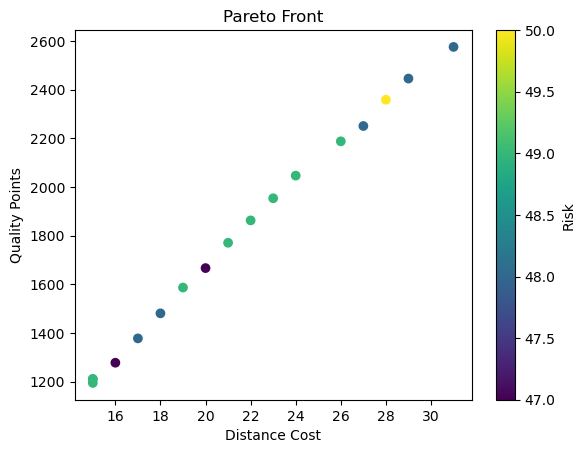

In [15]:
import matplotlib.pyplot as plt

distances, puntos, riesgos = zip(*respuestas)

plt.scatter(distances, puntos, c=riesgos, cmap='viridis')
plt.xlabel('Distance Cost')
plt.ylabel('Quality Points')
plt.colorbar(label='Risk')
plt.title('Pareto Front')
plt.show()